# Model prediction analysis

In [1]:
# Example usage:
from tqdm import tqdm
import numpy as np
from pathlib import Path
from utils import load_config, load_model, safe_load_pickle
import torch
from data.datasets import AppSequenceDataset, PreloadedDataset
from models.transformer_models import ShallowTransformerWithAttention
from torch.utils.data import DataLoader

# Load model and configuration
cfg_path = Path("config/train/default.yaml")
cfg = load_config(cfg_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model_path = Path(cfg.get("training", {}).get("save_model_path"))
model, app_to_idx = load_model(model_path, cfg, ShallowTransformerWithAttention, cfg, device)

# Load test sequences
test_sequences = safe_load_pickle(Path(cfg["data"]["sequences_path"]))



C:\Users\Nemanja\Documents\GitHub\focus-time\src\utils.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [2]:
from analysis.postprocess import predict_sequence_with_attention, analyze_attention_patterns, visualize_attention, plot_attention_heads


In [3]:
# Make predictions and get attention weights for a single sequence
sequence = test_sequences[0]
results, attention_weights = predict_sequence_with_attention(
    model, sequence, app_to_idx, device
)

# Analyze attention patterns
attention_analysis = analyze_attention_patterns(
    attention_weights, sequence, app_to_idx
)

# Print results
print("\nPredictions and Attention Analysis:")
print("\nTop Predictions:")
for r in results[:5]:  # Show first 5 positions
    print(f"\nPosition {r['position']}:")
    print(f"Actual app: {r['actual_app']}")
    print("Predictions:")
    for pred in r['predictions']:
        print(f"  - {pred['app']}: {pred['probability']:.3f}")

print("\nAttention Analysis:")
print("\nMost Attended Positions (Global):")
for pos in attention_analysis['most_attended_positions']:
    print(f"Position {pos['position']}: {pos['app']} "
            f"(Score: {pos['average_attention_score']:.3f})")

print("\nLayer-wise Attention Patterns (sample):")
layer_data = attention_analysis['layer_wise_patterns'][0]  # First layer
print(f"\nLayer {layer_data['layer']}:")
for pattern in layer_data['attention_patterns'][:20]:  # Show first 3 positions
    print(f"\nPosition {pattern['position']} ({pattern['current_app']}) attends to:")
    for attended in pattern['attended_to']:
        print(f"  - Position {attended['position']} ({attended['app']}): "
                f"score {attended['score']:.3f}")

Sequence length: 64
Attention mask sum: 64
App IDs shape: torch.Size([64])

Predictions and Attention Analysis:

Top Predictions:

Position 0:
Actual app: Workpuls
Predictions:
  - Workpuls: 0.690
  - Windows_Shell_Experience_Host: 0.118
  - Pause: 0.046

Position 1:
Actual app: Windows_Explorer
Predictions:
  - Windows_Explorer: 0.595
  - docs.google.com: 0.115
  - Private_Links: 0.063

Position 2:
Actual app: Private_Links
Predictions:
  - Workpuls: 0.479
  - Private_Links: 0.171
  - Skype: 0.076

Position 3:
Actual app: docs.google.com
Predictions:
  - docs.google.com: 0.299
  - Pause: 0.288
  - chatgpt.com: 0.126

Position 4:
Actual app: Private_Links
Predictions:
  - Private_Links: 0.465
  - Workpuls: 0.232
  - Skype: 0.090

Attention Analysis:

Most Attended Positions (Global):
Position 19: docs.google.com (Score: 0.020)
Position 31: Pause (Score: 0.019)
Position 22: Pause (Score: 0.019)
Position 27: Pause (Score: 0.019)
Position 62: docs.google.com (Score: 0.019)

Layer-wise Att

In [4]:
sequence = test_sequences[5]  # Get a sample sequence
tokens, attention_weights = visualize_attention(model, sequence, app_to_idx, device)

Number of attention layers: 3
Shape of first layer attention: torch.Size([1, 4, 64, 64])

Formatted attention weights shape: torch.Size([3, 1, 4, 64, 64])
Number of tokens: 64


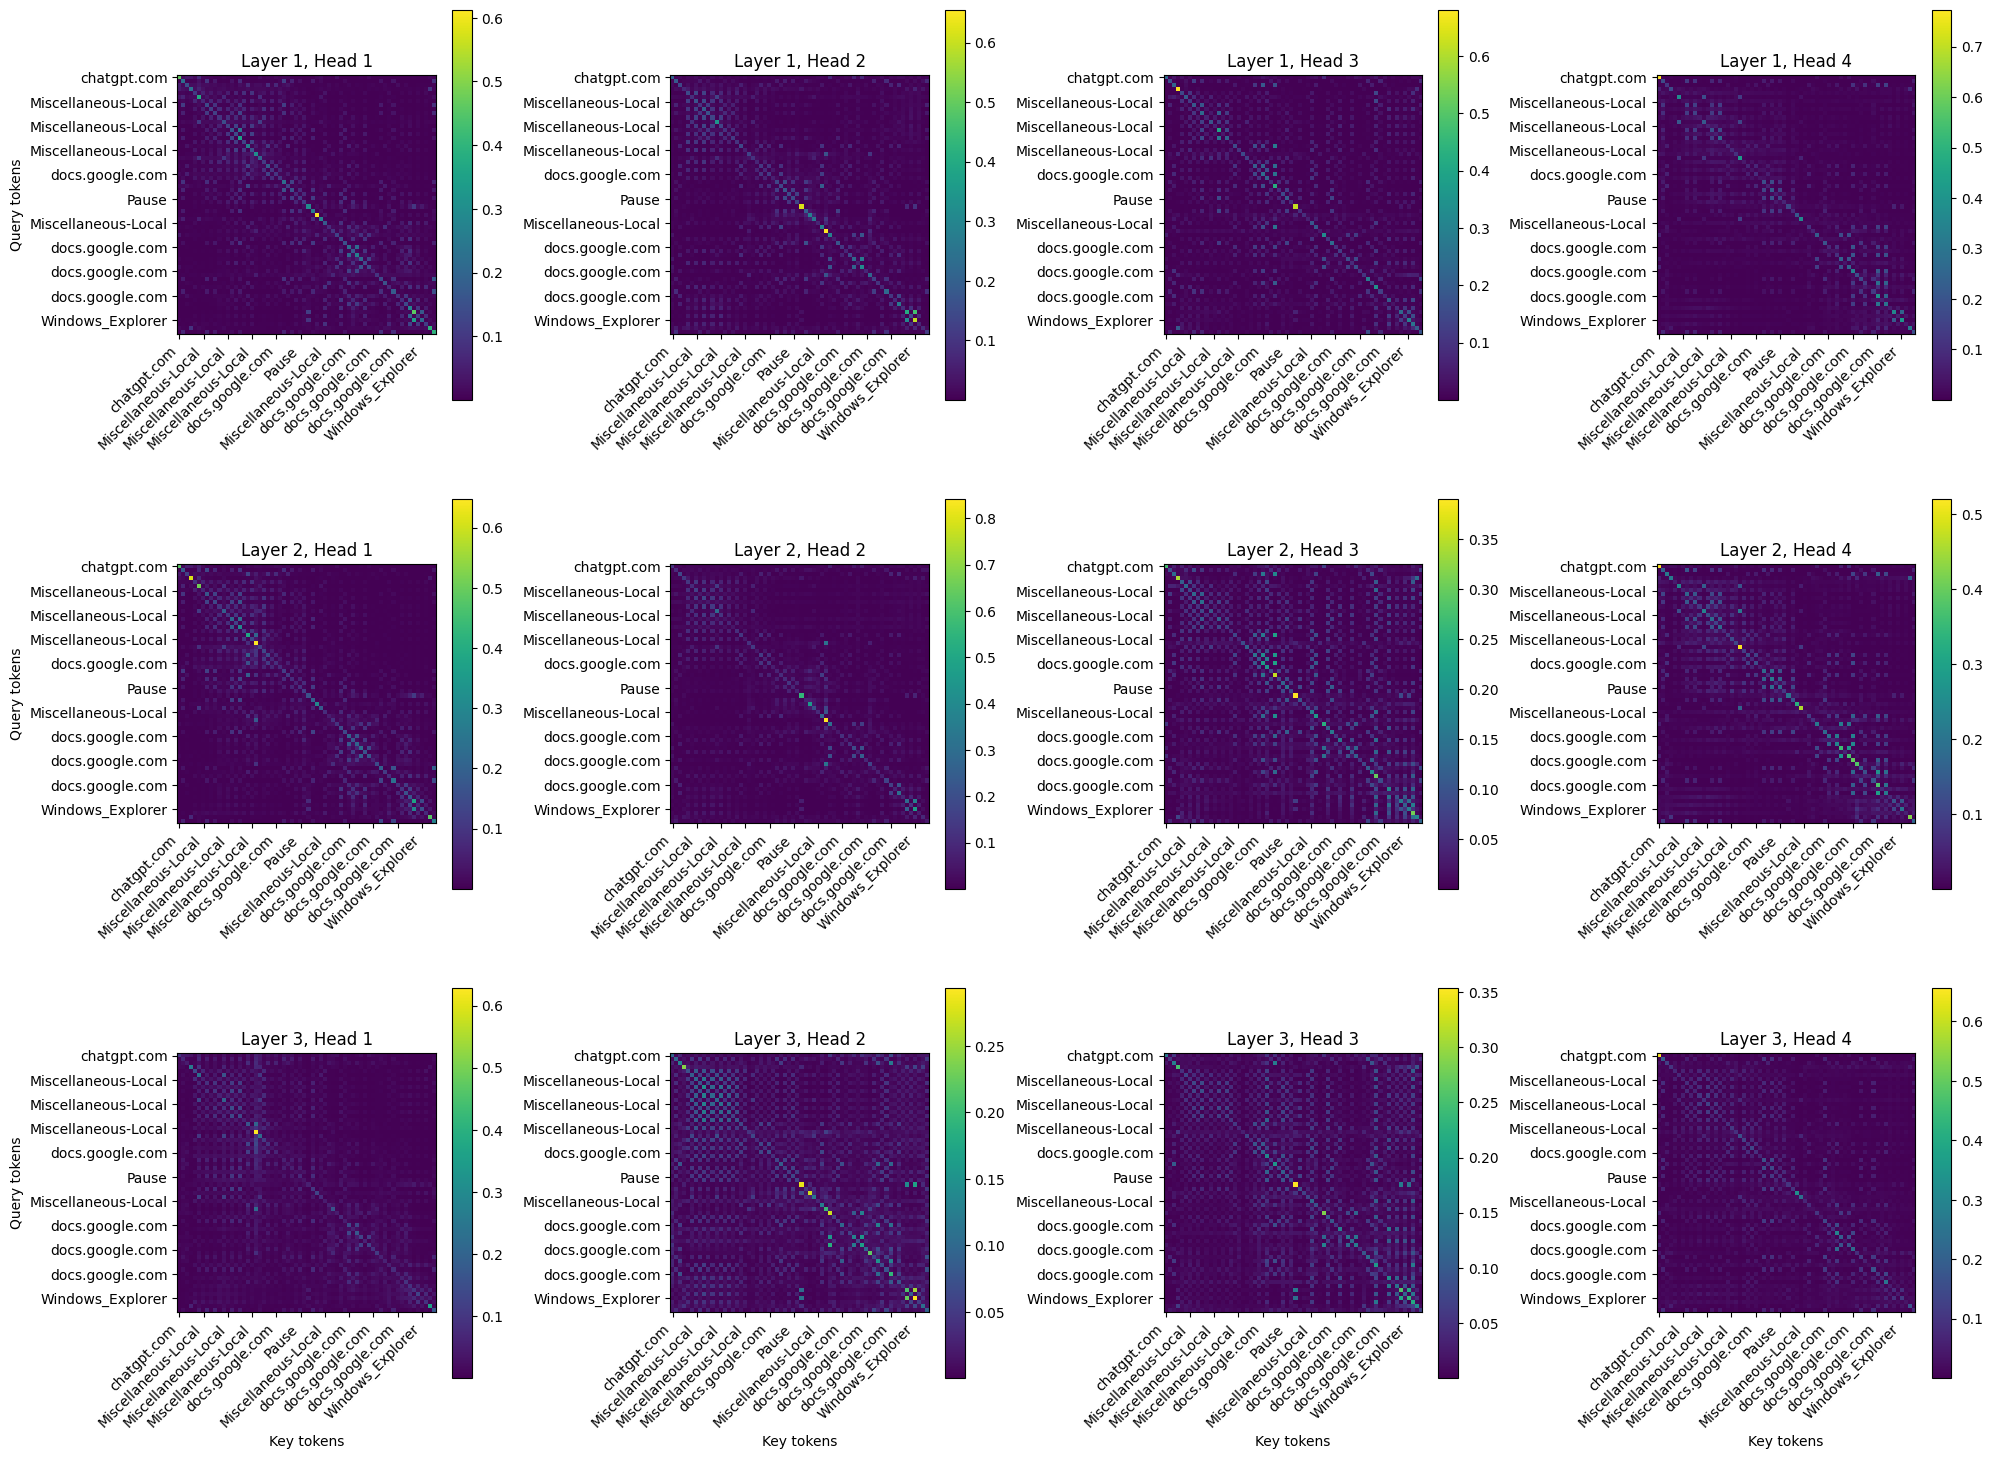

In [5]:
from matplotlib import pyplot as plt
fig = plot_attention_heads(attention_weights, tokens)
plt.show()

In [6]:
try:
    from bertviz import head_view
    from IPython.display import HTML
    import random
    import os
    sequence = test_sequences[100] 
    tokens, attention_weights = visualize_attention(model, sequence, app_to_idx, device)
    # Format attention weights for BertViz
    formatted_layers = attention_weights  # Keep as tensor
    
    # Generate HTML content as string
    html_content = head_view(formatted_layers, tokens, html_action="return")
    html_str = str(html_content)  # Convert HTML object to string
    
    # Save to file
    output_dir = 'visualizations'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'attention_viz_{random.randint(0, 10000)}.html')
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_str)  # Write the string version
    
    print(f"\nVisualization saved to: {output_file}")
    
    # Display in notebook
    display(html_content)  # Use display instead of returning HTML

except Exception as e:
    print(f"Error: {str(e)}")
    print("Full error:")
    import traceback
    traceback.print_exc()

Number of attention layers: 3
Shape of first layer attention: torch.Size([1, 4, 64, 64])

Formatted attention weights shape: torch.Size([3, 1, 4, 64, 64])
Number of tokens: 64

Visualization saved to: visualizations\attention_viz_9386.html


# Extract embeddings

In [7]:
import pandas as pd
from analysis.postprocess import extract_app_embeddings

# Extract embeddings
app_embeddings = extract_app_embeddings(model, app_to_idx, device)

# Convert to DataFrame for easier analysis
embeddings_df = pd.DataFrame.from_dict(app_embeddings, orient='index')

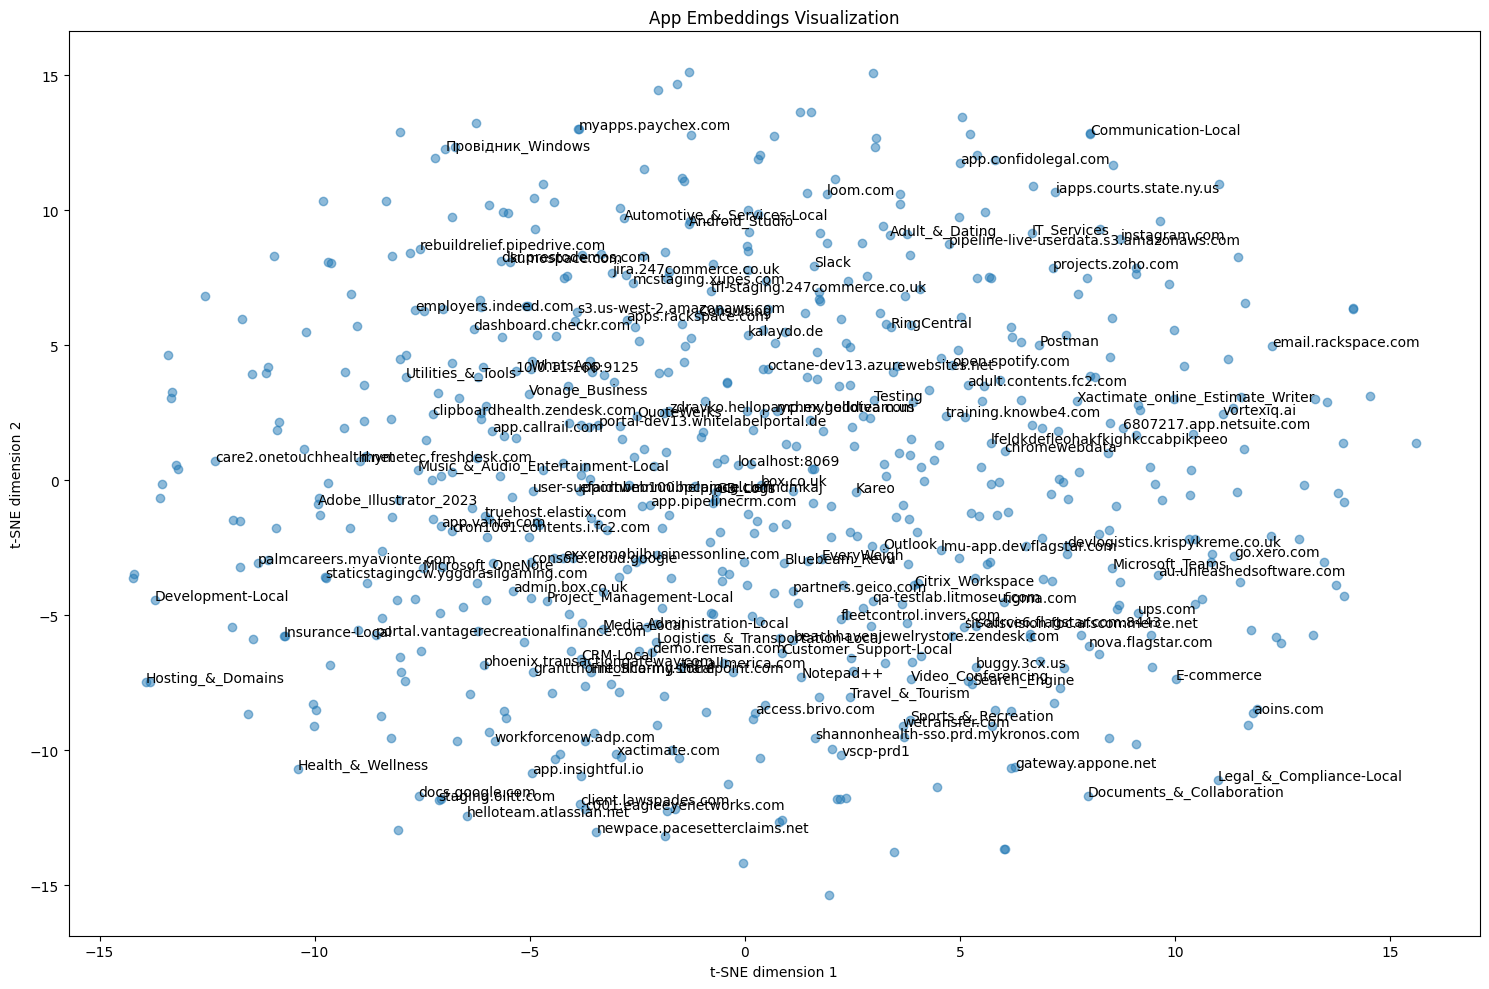


Number of apps with embeddings: 632
Embedding dimension: 64


In [8]:
embeddings_df# Reduce dimensionality for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# First reduce to 50 dimensions with PCA
pca = PCA(n_components=min(50, len(embeddings_df)))
embeddings_pca = pca.fit_transform(embeddings_df)

# Then reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Create visualization DataFrame
viz_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'], index=embeddings_df.index)

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(viz_df['x'], viz_df['y'], alpha=0.5)

# Add labels for some points (you might want to limit this to avoid overcrowding)
for idx, row in viz_df.iloc[::5].iterrows():  # Label every 5th point
    plt.annotate(idx, (row['x'], row['y']))

plt.title('App Embeddings Visualization')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.show()

# Print some statistics about the embeddings
print(f"\nNumber of apps with embeddings: {len(app_embeddings)}")
print(f"Embedding dimension: {embeddings_df.shape[1]}")



In [9]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
10.0.11.166:9125,0.136879,0.297357,0.136380,-0.822261,-0.718727,-0.148600,0.229973,-0.415831,0.415883,0.408319,...,-0.603223,0.350405,-0.438443,0.140814,1.210622,0.775054,-0.960066,-0.516084,0.820088,-1.057844
10.1.52.141:8124,0.364585,-0.224802,-1.514893,-1.109569,-0.871549,-2.021678,2.300409,-0.857356,0.457544,-0.138889,...,0.599746,0.311710,0.379975,0.894077,-0.163469,-0.273518,1.912780,-0.456215,1.794577,0.126364
10.2.2.18,0.352289,-0.207421,0.723828,0.626860,-0.799888,0.262071,0.374189,-1.143292,-0.283849,-0.510534,...,0.001818,-1.563439,-0.486283,2.109990,-0.197163,-1.384655,-0.063289,0.515904,0.270427,-1.349312
365online.com,-0.068484,-0.895110,0.540318,-0.546925,0.722989,0.561217,0.535320,-0.125238,-0.159560,0.264208,...,-0.749786,0.721970,0.261377,0.831329,-0.759468,-0.311827,1.000681,-0.798501,-1.157083,-0.533957
4dayjobs.de,-0.512472,-0.483302,-0.716536,0.651989,-0.986673,-0.651332,1.117383,-0.578258,0.466260,1.199504,...,0.123385,-0.999291,0.415734,0.247741,-0.410746,0.949896,-1.744068,1.049363,0.228873,-1.303027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinfandel.centrastage.net,-1.103672,-0.193471,0.793053,0.666640,-0.138334,-0.194626,-0.355928,0.466923,-0.075973,-0.222725,...,-1.283934,-1.177246,0.350958,-0.880603,-0.417186,0.363826,0.518431,0.875437,-0.887409,0.143749
zinfandel.rmm.datto.com,-0.328623,-0.512640,-0.346099,0.364914,0.533761,1.081995,0.623842,-0.435762,-0.435344,-0.513233,...,0.768737,-0.755566,-1.090696,-0.005438,0.278523,1.769210,-0.352816,-0.030528,-1.122326,-0.868309
Проводник,1.474719,-0.355404,-1.014271,-1.282381,0.962329,-0.961546,-0.410929,-1.432647,0.339138,2.222997,...,0.023493,-0.112729,0.037336,0.451163,-0.515669,-0.148857,-0.087217,-0.321719,1.482715,0.770987
Провідник_Windows,2.081244,-0.999177,-0.022980,-0.383496,0.631652,-0.189400,0.485295,0.487799,0.329845,0.480585,...,1.315341,-0.276214,0.446390,-0.156473,-0.474528,0.479149,-0.560102,1.296688,0.736727,0.714849


In [10]:
# Perform clustering and create interactive visualization
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_df)

# Perform clustering
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)

# Create t-SNE visualization with clusters
pca = PCA(n_components=min(50, len(embeddings_df)))
embeddings_pca = pca.fit_transform(embeddings_df)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'app': embeddings_df.index,
    'cluster': [f'Cluster {i}' for i in clusters]
})

# Create figure
fig = go.Figure()

# Add traces for each cluster
for cluster in sorted(viz_df['cluster'].unique()):
    cluster_data = viz_df[viz_df['cluster'] == cluster]
    
    # Add scatter plot for points
    fig.add_trace(
        go.Scatter(
            x=cluster_data['x'],
            y=cluster_data['y'],
            mode='markers',
            name=cluster,
            hovertext=cluster_data['app'],
            hoverinfo='text',
            showlegend=True,
            visible='legendonly'  # This makes the cluster hidden by default
        )
    )

# Add text labels for some points (every 10th point)
fig.add_trace(
    go.Scatter(
        x=viz_df.iloc[::10]['x'],
        y=viz_df.iloc[::10]['y'],
        mode='text',
        text=viz_df.iloc[::10]['app'],
        textposition="top center",
        name='Labels',
        showlegend=True,
        visible='legendonly'  # This makes the labels hidden by default
    )
)

# Update layout
fig.update_layout(
    title='App Embeddings Visualization (Clustered)',
    title_x=0.5,
    width=1200,
    height=800,
    xaxis_title='t-SNE dimension 1',
    yaxis_title='t-SNE dimension 2',
    hovermode='closest',
    legend_title='Clusters'
)

# Show the plot
fig.show()

# Print cluster statistics
print("\nCluster Statistics:")
cluster_stats = viz_df.groupby('cluster')['app'].agg(['count'])
print(cluster_stats)

# Print sample apps from each cluster
print("\nSample apps from each cluster:")
for cluster in sorted(viz_df['cluster'].unique()):
    sample_apps = viz_df[viz_df['cluster'] == cluster]['app'].sample(min(5, len(viz_df[viz_df['cluster'] == cluster]))).tolist()
    print(f"\n{cluster}:")
    print(sample_apps)


Cluster Statistics:
            count
cluster          
Cluster 0      15
Cluster 1      40
Cluster 10     31
Cluster 11     30
Cluster 12     51
Cluster 13     44
Cluster 14     47
Cluster 2      40
Cluster 3      44
Cluster 4      66
Cluster 5      52
Cluster 6      33
Cluster 7      56
Cluster 8      40
Cluster 9      43

Sample apps from each cluster:

Cluster 0:
['workdrive.zoho.com', 'Cybersecurity', 'app.callrail.com', 'admin.dev.1939api.com', 'Surveys_&_Research']

Cluster 1:
['Hosting_&_Domains', 'Discord', 'translate.google.com', 'Communication-Local', 'WhatsApp']

Cluster 10:
['vortexiq.ai', 'Music_&_Audio_Entertainment-Local', 'voyagm.monday.com', 'E-commerce', 'justcall.io']

Cluster 11:
['clipboardhealth.zendesk.com', 'VMware_Workstation', 'app.detrack.com', 'Snagit', '365online.com']

Cluster 12:
['docs.google.com', 'source6.flagstar.com:8443', 'app.ramp.com', 'udemytestsuite.testrail.io', 'outlook.office.com']

Cluster 13:
['staging.olitt.com', 'pipeline-live-userdata.

In [12]:
from analysis.postprocess import find_similar_apps
# Example: Find similar apps for a few examples
example_apps = pd.Series(app_to_idx).sample(10).index.tolist()  # Replace with actual apps in your dataset
for app in example_apps:
    if app in embeddings_df.index:
        print(f"\nApps similar to {app}:")
        similar_apps = find_similar_apps(app, embeddings_df)
        for similar_app, similarity in similar_apps.items():
            print(f"  - {similar_app}: {similarity:.3f}")


Apps similar to Search_Engine-Local:
  - Printing_&_Publishing-Local: 0.389
  - link.24hrcash.ca: 0.332
  - gtmdjd.com: 0.318
  - Operating_System-Local: 0.300
  - care2.onetouchhealth.net: 0.298

Apps similar to web.skype.com:
  - translate.google.com.ua: 0.388
  - app.justcall.io: 0.360
  - discord.com: 0.322
  - Mail-Local: 0.309
  - Workpuls: 0.306

Apps similar to cron1001.market.i.laxd.com:
  - Adobe_Illustrator_2023: 0.419
  - palmcareers.lightning.force.com: 0.385
  - app.alegra.com: 0.382
  - cron1001.contents.i.fc2.com: 0.358
  - diffchecker.com: 0.349

Apps similar to colab.research.google.com:
  - claude.ai: 0.488
  - Aircall: 0.397
  - solvealltest.develop.helloteam.us: 0.394
  - mcstaging2.krispykreme.co.uk: 0.379
  - yourfirm.de: 0.366

Apps similar to Video_Conferencing:
  - sherlock.epic.com: 0.406
  - dell.com: 0.404
  - Automotive_&_Services-Local: 0.344
  - quora.com: 0.329
  - people.zoho.com: 0.327

Apps similar to phoenix.transactiongateway.com:
  - Database_Man

In [43]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,cluster
10.0.11.166:9125,0.004258,-0.532749,2.599877,0.458689,-1.067049,-0.996625,-0.229606,-1.244702,-0.137633,-0.078723,...,1.358217,-0.226026,-1.522789,0.723157,0.204177,-0.012799,1.094092,0.525360,-1.415506,3
10.1.52.141:8124,1.053942,0.382068,1.007349,0.472141,0.856217,0.945621,-0.643211,-1.376202,0.762523,-0.471287,...,-0.163311,-0.689626,-0.170979,0.475315,0.045049,0.254526,0.119112,-0.946172,-0.439092,3
10.2.2.18,-0.497314,-1.269500,0.373027,0.505372,0.281695,0.139899,-0.088666,-1.947264,1.473649,0.225129,...,0.050761,-0.198983,0.377130,1.164468,0.185942,1.435670,-0.066790,-0.972795,-0.376276,3
365online.com,-0.866841,-0.934161,-0.368434,-0.015966,1.092410,0.283961,0.158620,0.980897,0.009619,-1.143962,...,-0.879877,0.901460,0.962048,-0.270547,0.527974,-0.281691,-1.012674,-0.036263,0.081923,1
4dayjobs.de,1.229383,-1.374235,0.003328,1.304873,-0.802636,0.773421,-0.078264,-0.661607,0.315794,0.629914,...,-0.411126,-1.044157,-0.140848,-0.216533,0.701100,0.535221,-1.509207,0.047061,0.043851,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinfandel.centrastage.net,0.237094,-0.231419,0.471820,-0.443814,-2.176877,1.434099,-0.727126,0.786214,0.943220,0.000467,...,1.143818,0.085358,-1.187329,-0.492394,0.963912,0.704136,-0.878463,0.172940,0.111727,4
zinfandel.rmm.datto.com,-0.539295,1.088092,-0.252163,0.340581,1.003055,-0.200825,0.702202,0.392789,0.652685,1.972360,...,0.406505,1.220354,-1.039635,1.022919,0.483381,-0.720903,0.179731,-0.910563,0.922427,0
Проводник,0.273098,0.489983,0.431667,-0.414550,0.396709,-1.046934,-0.554838,-0.350716,-0.503817,-0.796073,...,0.049339,-0.370496,-0.102375,3.640990,0.022023,0.646921,0.128767,0.384479,-0.492706,0
Провідник_Windows,1.046615,0.581591,-1.152687,0.890545,-1.418524,0.244538,-0.219951,0.893883,0.037262,-0.004052,...,0.110913,-1.180264,-0.012197,-0.433582,-1.947287,-0.530669,0.734337,1.569759,-1.539934,0


In [13]:
# Perform clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the embeddings
scaler = StandardScaler()
if 'cluster' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['cluster'])
scaled_embeddings = scaler.fit_transform(embeddings_df)

# Try different numbers of clusters
n_clusters = 30  # Adjust this number based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)

# Add cluster labels to DataFrame
embeddings_df['cluster'] = clusters

# Analyze clusters
for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    apps_in_cluster = embeddings_df[embeddings_df['cluster'] == cluster_id].index.tolist()
    print(f"Number of apps: {len(apps_in_cluster)}")
    print("Sample apps:")
    print(apps_in_cluster[:10]) 


Cluster 0:
Number of apps: 7
Sample apps:
['admin.dev.1939api.com', 'app.callrail.com', 'console.cloud.google.com', 'discord.com', 'portal-lasc.journaltech.com', 'vscp-prd1', 'workdrive.zoho.com']

Cluster 1:
Number of apps: 36
Sample apps:
['Adult_&_Dating', 'Analytics', 'Citrix_Workspace', 'Communication-Local', 'Construction', 'Education_&_Learning', 'Hospitality', 'Hyperdrive', 'IT_Services', 'Notes-Local']

Cluster 2:
Number of apps: 29
Sample apps:
['Adobe_Photoshop_2024', 'AutoCAD', 'Cursor', 'GB_Logs', 'IoT', 'Microsoft_Calculator', 'Microsoft_OneNote', 'Microsoft_Word', 'Outlook', 'Project_Management-Local']

Cluster 3:
Number of apps: 15
Sample apps:
['Adobe_Acrobat_DC', 'Health_&_Wellness-Local', 'Kareo', 'Search_Engine-Local', 'Vysor', 'dice.com', 'eu2-cloud.acronis.com', 'fleetcontrol.invers.com', 'justcall.io', 'kards.exe']

Cluster 4:
Number of apps: 23
Sample apps:
['Android_Studio', 'Calendar_&_Scheduling', 'Construction-Local', 'DraftworX', 'Finder', 'Sales', 'Slack'